<a href="https://colab.research.google.com/github/vmendesmagalhaes/machine-learning/blob/main/Predicao_umidade_madeira.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Variation of moisture content on wood prediction

**Autor:** Vitor Mendes Magalhaes

**Email:** vitor.mendes.magalhaes@gmail.com

**Data da última atualização:** 07/02/2023

Let's start by loading the libraries.

In [ ]:
import pandas as pandas
import numpy as numpy
import matplotlib.pyplot as matplot
import seaborn as seaborn
from sklearn.model_selection import train_test_split as createDataPartition
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix

The next step is importing the spreadsheet (.XLS file).

In [ ]:
dados = pandas.read_excel('datasetjan23.xls')

First, let's create a new attribute, called *PERCENTUAL*. It means the percentage of weight loss in relation to the total amount of incoming wood logs in each pile.

In [ ]:
dados['PERCENTUAL'] = (dados['ESTORNO'] * 100) / dados['TOT_ENTR']

After creating the new attribute, we will remove the instances of stacks that did not have log outputs. In theory, if they do not represent an operational error, these piles continued to receive loads of wood, or were not yet closed, at the time of data capture.

We will also remove instances of piles that have not had reversed charges, that is, that in theory there was no loss of moisture. In the case of wood logs stored outdoors (technically, it is called "natural drying"), under the conditions of the captured data, there will always be moisture loss.

In [ ]:
dados.drop(dados[dados['TOT_SAID'] == 0].index, inplace=True)
dados.drop(dados[dados['ESTORNO'] == 0].index, inplace=True)

After removing the instances, let's create copies of the original dataset, which will be used to train different problem solving models using supervised learning: classification models (for different classes) and regression models.

In [ ]:
dfClassificacao = dados
dfRegressao = dados

Now, let's start the pre-processing step, removing the attributes that are not interesting for creating the learning models to be applied.

Once this is done, we will continue pre-processing the data, now with a selection of features, removing attributes and biasing the data to conform to the type of supervised learning they propose.

To create the regression model, we will remove the stack identification (*PILHA*), the total outputs (*TOT_SAID*), the difference between the input and output (*DIFERENCA*), the dates (*DATA_INICIO* and *DATA_FIM*) and the amount reversed (*ESTORNO*).

Thus, we make it clear that the class we want to predict is the *PERCENTUAL* of weight loss relative to the total wood input in the pile.

In [ ]:
dfRegressao = dfRegressao.drop(["PILHA", "TOT_SAID", "DIFERENCA", "DATA_INICIO", "DATA_FIM", "ESTORNO"], axis=1)

For the creation of classification models, let's create a new attribute, called *INTERVALOPERDA*. Loss ranges are nothing more than weight loss percentage ranges, eg between 0% and 5% loss; between 5% and 10% loss, and so on, as far as the data allows.

To define the best weight loss percentage ranges, we will first analyze visually, using three different visual analysis tools: a *boxplot*, a summary of the *PERCENTUAL* attribute (which will dictate the ranges), and a histogram with the frequency of instances with different percentages.

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

In [ ]:
dfClassificacao['PERCENTUAL'].hist()

In [ ]:
dfClassificacao.describe()

In a brief analysis, it is noticed that there are possible operational errors that can generate noise in the classification model, allowing them to be considered outliers.

A clear example is the loss percentage. There are percentages that tend to 100%, which does not occur in this process; there are also percentages that tend to 0% - same situation.

So let's remove the instances with losses above 40%.

In [ ]:
dfClassificacao = dfClassificacao.drop(dfClassificacao[dados['PERCENTUAL'] >= 40].index)

Afterwards, let's check again through the *boxplot*.

In [ ]:
dfClassificacao.boxplot(column =['PERCENTUAL'], grid = True)

Now we can return to the creation of the attribute *INTERVALOPERDA*, establishing different intervals of loss percentages:

DESCRIÇÃO | INTERVALO
--- | ---
1 | less than 10%
2 | between 10% and 20%
3 | between 20% and 30%
4 | more than 30%

In [ ]:
for i, linha in dfClassificacao.iterrows():
  if (linha['PERCENTUAL'] <= 10):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 1;
  elif ((linha['PERCENTUAL'] > 10) and (linha['PERCENTUAL'] <= 20)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 2;
  elif ((linha['PERCENTUAL'] > 20) and (linha['PERCENTUAL'] <= 30)):
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 3;
  else:
    dfClassificacao.loc[i, 'INTERVALOPERDA'] = 4;

Once the *INTERVALOPERDA* attribute is created, let's remove the attributes that will not be important for the creation of the learning models - more specifically, the classification.

In this sense, we will remove the stack identification (*PILHA*), the dates (*DATA_INICIO* and *DATA_FIM*, the output weight (*TOT_SAID*), the difference between the input and output totals (*DIFERENCA*) , the amount reversed (*ESTORNO*) and the percentage (*PERCENTUAL*).

Thus, we make it clear that the class we want to predict is the *INTERVALOPERDA*, just created, which contains the interval (in percentage) of wood weight loss.

In [ ]:
dfClassificacao = dfClassificacao.drop(["PILHA", "DATA_INICIO", "DATA_FIM", "TOT_SAID", "DIFERENCA", "ESTORNO", "PERCENTUAL"], axis=1)

After creating the attribute (class) that will be our target, and removing the attributes that will not be predictors of our models, we will check the balance of the dataset.

In [ ]:
print(dfClassificacao['INTERVALOPERDA'].value_counts())

We can clearly observe that the largest number of instances is represented in classes 1 and 2, that is, the vast majority of the piles present in the dataset have a weight loss (due to the loss of moisture content) of less than 20%.

We will verify the integrity of these data, analyzing the moisture losses from the piles in relation to the number of days that the logs remained stored (in the same piles).

In [ ]:
print(dfClassificacao['QTD_DIAS'].describe())

Considering, then, that when it comes to loss of moisture content in wood stored outdoors (*natural drying*) 20% is a small percentage, it can be easily inferred that these logs, due to the large number of days average battery life (81 days), had already been cut longer.

As there are non-numeric predictor attributes, we need to treat them, transforming them into numerical attributes so that we can proceed with the training of the learning models (in Weka, in R and in other environments/languages, this transformation is not necessary, but it is need to analyze possible differences in the prediction result).

Let's do the *one-hot-encoding* for categorical attributes that don't have any need for sorting, like product, bark, and species.

In [ ]:
atributos_a_codificar = ['PRODUTO', 'CASCA', 'ESPECIE', 'DIAMETRO']

atributos_codificados = pandas.get_dummies(dfClassificacao[atributos_a_codificar])

dfClassificacao = dfClassificacao.drop(atributos_a_codificar, axis=1).join(atributos_codificados)

The dataset has not yet been partitioned, and the tendency is for the partitions to reproduce the general behavior of the dataset. So let's split it before solving the class imbalance problem.

In [ ]:
dados_treino, dados_teste, classe_treino, classe_teste = createDataPartition(dfClassificacao, dfClassificacao['INTERVALOPERDA'], test_size=0.25)


In [ ]:
#classe_teste.head(10)

Thus, with the dataset partitioned with 75% of the data separated for training, and 25% for testing, we can proceed with the training of the models, with the data already biased towards supervised learning - classification.

Let's then instantiate the classification model using the *Random Forest* (RF) algorithm.

In [ ]:
rf = RandomForestClassifier()

Once the model is instantiated, it is time to train the classification model.

In [ ]:
rf.fit(dados_treino, classe_treino)

Once the model is trained (using both the training data and the training class), the next step is to verify the predictions, that is, what in fact the created model was able to learn from the available data.

In [ ]:
predicoes = rf.predict(dados_teste)

Keeping the predictions in a variable, we will check through a confusion matrix the results of the learning model predictions using classification with RF.

In [ ]:
cm = confusion_matrix(classe_teste, predicoes)

cm

Observing the confusion matrix above, one can notice the assertiveness of the chosen method. But we need to make the information clearer.

For this, we are going to use some metrics, starting with the accuracy of the model, that is, how much, in percentage, the model is able to hit its predictions (always based on the data that the model had at its disposal).

In [ ]:
print("Acurácia:", metrics.accuracy_score(classe_teste, predicoes))

Acurácia: 0.9180327868852459


It is important to keep in mind that, although accuracy is the proportion of correct predictions in relation to the total number of predictions, it is a simple metric, that is, it may not always be the most suitable metric - especially in unbalanced datasets.

<BarContainer object of 32 artists>

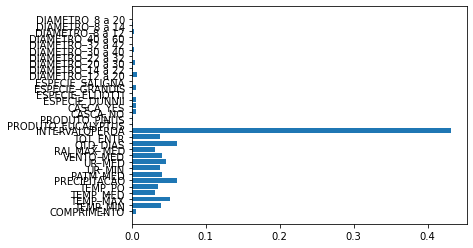

In [ ]:
# Calcule a importância das features
importance = rf.feature_importances_

importance

# Crie um gráfico para visualizar a importância das features
matplot.barh(dados_teste.columns, importance)
#matplot.xlabel('Importância da Feature')
#matplot.ylabel('Feature')
#matplot.title('Importância das Features no Modelo Random Forest')

# Mostre o gráfico
#matplot.show()